In [1]:
from src.neural_process import NP
from src.image_dataset import NPImageDataset
from src.trainer import TrainModel
import torch
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from glob import glob
import numpy as np
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint


# TODO 
# support keys with more than one dim
# implement kernel attention + viz
# implement setconv attention
# celeb dataset
# gaussian process dataset
# eval logic

In [2]:
celebA_img_paths = glob("/home/fabiograetz/ml/experiments/data/CelebA/Img/img_align_celeba/*.jpg")

In [3]:
size = 80
num_y = 6000
ds = NPImageDataset(celebA_img_paths, size, size, s=num_y)

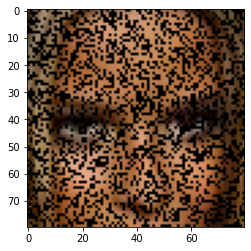

In [4]:
xs, ys = ds[0]
img = torch.zeros((3, size, size))
for (r,c), y in zip(xs, ys):
    img[:,r.int(),c.int()] = y
plt.imshow(img.numpy().transpose(1,2,0))

In [ ]:
# https://github.com/soobinseo/Attentive-Neural-Process
model = NP(indim=2, outdim=3)
trainmodel = TrainModel(model, max_context_points=num_y)

checkpoint_callback = ModelCheckpoint(
    filepath='/home/fabiograetz/ml/experiments/data/models',
    verbose=True,
)


trainer = pl.Trainer(max_epochs=2, gpus=torch.cuda.device_count(), progress_bar_refresh_rate=20, checkpoint_callback=checkpoint_callback)
trainer.fit(trainmodel, DataLoader(ds, batch_size=24))



/home/fabiograetz/ml/experiments/src/modules.py:153: UserWarning: hidden_size=32 smaller than output=64 and input=64. Setting it to 64.
  warnings.warn(
GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | NP   | 200 K 
-------------------------------
197 K     Trainable params
2.6 K     Non-trainable params
200 K     Total params
/home/fabiograetz/anaconda3/envs/pytorch/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:49: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)


Training: |          | 0/? [00:00<?, ?it/s]

In [ ]:
import matplotlib.pyplot as plt

plt.plot([a['loss'] for a in trainmodel.my_log])
#plt.ylim(0, 0.1)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

xs = np.linspace(-1.25, 1.25, 100, dtype=np.float32)
x, y, a = sample_ds(n=10)
 
#gt
plt.plot(xs, sinc(xs, a), 'g')
 
# context
#context = torch.cat([torch.tensor(x).view([-1, 1]), torch.tensor(y).view([-1, 1])], 1).view([1, -1, 2])[:, :model.num_y]
#plt.scatter(x[:model.num_y], y[:model.num_y], c='g')
context = torch.cat([torch.tensor(x).view([-1, 1]), torch.tensor(y).view([-1, 1])], 1).view([1, -1, 2])
plt.scatter(x, y, c='g')
 
# pred
x_pred = []
y_pred = []
y_std_pred = []
q = torch.tensor(xs).view([1, -1, 1])
for i in range(q.size()[1]):
    a_q = q[0:1, i:i+1, :]
    ret_mu, ret_sigma = model(context, a_q)
    x_pred.append(q[0, i, 0].detach().numpy())
    y_pred.append(ret_mu[0, 0, 0].detach().numpy())
    y_std_pred.append(ret_sigma[0, 0, 0].detach().numpy())

plt.ylim([-1, 1])
plt.axvline(x=-1, ls=':', c='black')
plt.axvline(x=1, ls=':', c='black')
plt.plot(x_pred, y_pred, c='r')
plt.fill_between(x_pred, [y_pred[i]-y_std_pred[i] for i in range(len(x_pred))], [y_pred[i]+y_std_pred[i] for i in range(len(x_pred))], color='r', alpha=0.2)

In [ ]:
#viz kernel fourier features
for ca in list(model.cross_attentions): #z_attentions self_attentions
    ca.multihead.viz_kernel_in_fourier_domain()

In [ ]:
#viz kernel fourier features
for ca in list(model.cross_attentions):#+list(model.self_attentions): #z_attentions self_attentions
    ca.multihead.viz_kernel_in_spatial_domain()